In [18]:
import sys, os, re
print("Kernel Python:", sys.executable)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import random
import matplotlib.cm as cm

import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import torch.nn.functional as F

import umap  # Requires: pip install umap-learn

# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /work3/s232958/envs/esm_cuda/bin/python3.10


first you need to run `02_ESMC_encoding_some_PDB_seqs.ipynb` to generate ESM_C encodings for some of the proteins from PPint

In [8]:
meta_Df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")
targets = meta_Df.target_id_mod.unique()
meta_targets_encodings_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_targets"
meta_targets_encodings_files = sorted(os.listdir(meta_targets_encodings_path))
meta_targets = [np.load(os.path.join(meta_targets_encodings_path, f))[0] for f in meta_targets_encodings_files]

boltzgen_Df = pd.read_csv("/work3/s232958/data/boltzgen/boltzgen_df_filtered.csv")
targets = boltzgen_Df.target_id.unique()

boltzgen_encodings_path = "/work3/s232958/data/boltzgen/embeddings_esmC"
boltzgen_encodings_files = sorted(os.listdir(boltzgen_encodings_path))

targets_files, binders_files = [], []
for file in boltzgen_encodings_files:
    if file.split(".")[0] in targets:
        targets_files.append(file)
    else:
        binders_files.append(file)
boltzgen_targets = [np.load(os.path.join(boltzgen_encodings_path, f))[0] for f in targets_files]

bindcraft_Df = pd.read_csv("/work3/s232958/data/bindcraft/bindcraft_with_target_seq.csv")
targets = bindcraft_Df.target_id.unique()

bindcraft_encodings_path = "/work3/s232958/data/bindcraft/embeddings_esmC"
bindcraft_encodings_files = sorted(os.listdir(bindcraft_encodings_path))

targets_files, binders_files = [], []
for file in bindcraft_encodings_files:
    if file.split(".")[0] in targets:
        targets_files.append(file)
    else:
        binders_files.append(file)

bindcraft_targets = [np.load(os.path.join(bindcraft_encodings_path, f))[0] for f in targets_files]

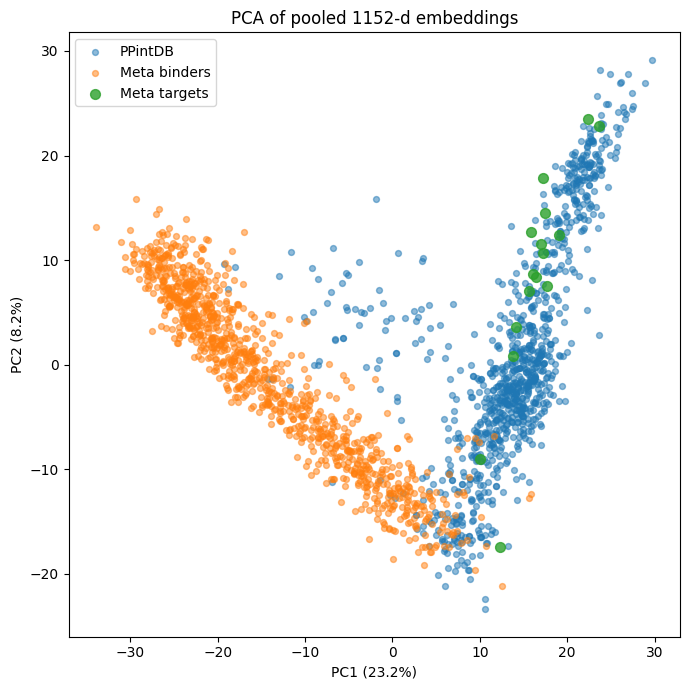

In [7]:
# 1) Pool per-sample (mean over residues) -> (Ni, 1152)
pooled_PPintDB       = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)        # (N1, 1152)
pooled_meta_binders  = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)    # (N2, 1152)
pooled_meta_targets  = np.stack([arr.mean(axis=0) for arr in meta_targets_embedings], axis=0)    # (N3, 1152)

# 2) Standardize jointly (important!)
X_all = np.vstack([pooled_PPintDB, pooled_meta_binders, pooled_meta_targets])  # (N1+N2+N3, 1152)
X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3, 2)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]

Z_PPintDB       = Z_all[:N1]
Z_meta_binders  = Z_all[N1:N1+N2]
Z_meta_targets  = Z_all[N1+N2:N1+N2+N3]   # or simply Z_all[N1+N2:]

# 5) Plot
plt.figure(figsize=(7,7))
plt.scatter(Z_PPintDB[:,0],      Z_PPintDB[:,1],      s=18, alpha=0.5, label="PPintDB",        marker='o')
plt.scatter(Z_meta_binders[:,0], Z_meta_binders[:,1], s=18, alpha=0.5, label="Meta binders",   marker='o')
plt.scatter(Z_meta_targets[:,0], Z_meta_targets[:,1], s=50, alpha=0.8, label="Meta targets",   marker='o')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_3337461/2219451737.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20_r', 7)


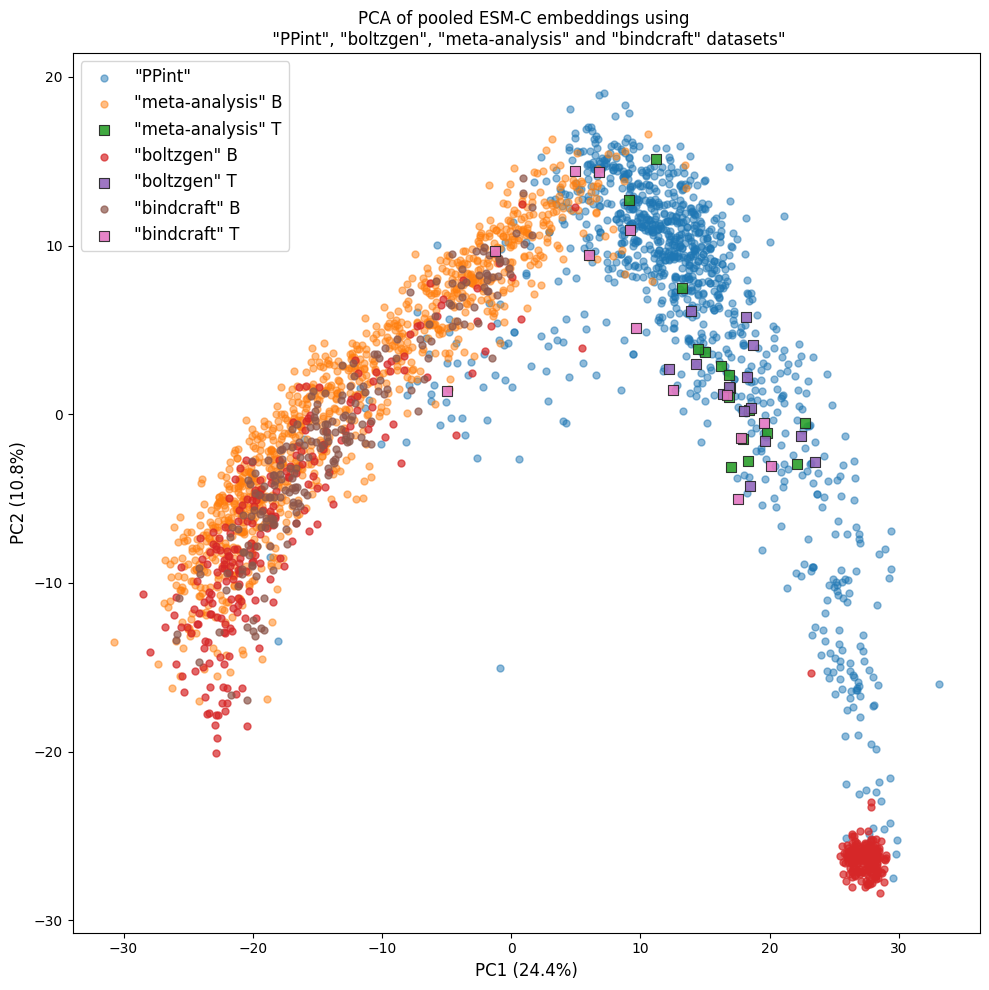

In [8]:
# 1) Pool per-sample (mean over residues) -> (Ni, 1152)
pooled_PPintDB            = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)           # (N1, 1152)
pooled_boltzgen_binders   = np.stack([arr.mean(axis=0) for arr in boltzgen_binders_embedings], axis=0)   # (N2, 1152)
pooled_boltzgen_targets   = np.stack([arr.mean(axis=0) for arr in boltzgen_targets_embedings], axis=0)   # (N3, 1152)
pooled_meta_binders       = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)       # (N4, 1152)
pooled_meta_targets       = np.stack([arr.mean(axis=0) for arr in meta_targets_embedings], axis=0)       # (N5, 1152)
pooled_bindcraft_binders   = np.stack([arr.mean(axis=0) for arr in bindcraft_binders_embedings], axis=0)   # (N2, 1152)
pooled_bindcraft_targets   = np.stack([arr.mean(axis=0) for arr in bindcraft_targets_embedings], axis=0)   # (N3, 1152)

# 2) Standardize jointly (important!)
X_all = np.vstack([
    pooled_PPintDB,
    pooled_meta_binders,
    pooled_meta_targets,
    pooled_boltzgen_binders,
    pooled_boltzgen_targets,
    pooled_bindcraft_binders,
    pooled_bindcraft_targets
]) 

X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3+N4+N5, 2)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]
N4 = pooled_boltzgen_binders.shape[0]
N5 = pooled_boltzgen_targets.shape[0]
N6 = pooled_bindcraft_binders.shape[0]
N7 = pooled_bindcraft_targets.shape[0]

Z_PPintDB            = Z_all[:N1]
Z_meta_binders       = Z_all[N1:N1+N2]
Z_meta_targets       = Z_all[N1+N2:N1+N2+N3]  # remaining rows
Z_boltzgen_binders   = Z_all[N1+N2+N3:N1+N2+N3+N4]
Z_boltzgen_targets   = Z_all[N1+N2+N3+N4:N1+N2+N3+N4+N5]
Z_bindcraft_binders   = Z_all[N1+N2+N3+N4+N5:N1+N2+N3+N4+N5+N6]
Z_bindcraft_targets   = Z_all[N1+N2+N3+N4+N5+N6:N1+N2+N3+N4+N5+N6+N7]


# 5) Plot
colors = cm.get_cmap('tab20_r', 7)
plt.figure(figsize=(10, 10))
plt.scatter(Z_PPintDB[:, 0],          Z_PPintDB[:, 1],          s=25, alpha=0.5, label='"PPint"',           marker='o')
plt.scatter(Z_meta_binders[:, 0],     Z_meta_binders[:, 1],     s=25, alpha=0.5, label='"meta-analysis" B',      marker='o')
plt.scatter(Z_meta_targets[:, 0],     Z_meta_targets[:, 1],     s=50, alpha=0.9, label='"meta-analysis" T',      marker='s', edgecolors='#222222', linewidths=0.8)

plt.scatter(Z_boltzgen_binders[:, 0], Z_boltzgen_binders[:, 1], s=25, alpha=0.7, label='"boltzgen" B',  marker='o')
plt.scatter(Z_boltzgen_targets[:, 0], Z_boltzgen_targets[:, 1], s=50, alpha=0.9, label='"boltzgen" T',  marker='s', edgecolors='#222222', linewidths=0.8)

plt.scatter(Z_bindcraft_binders[:, 0], Z_bindcraft_binders[:, 1], s=25, alpha=0.7, label='"bindcraft" B',  marker='o')
plt.scatter(Z_bindcraft_targets[:, 0], Z_bindcraft_targets[:, 1], s=50, alpha=0.9, label='"bindcraft" T',  marker='s', edgecolors='#222222', linewidths=0.8)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize = 12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize = 12)
plt.title('PCA of pooled ESM-C embeddings using \n "PPint", "boltzgen", "meta-analysis" and "bindcraft" datasets"')
plt.legend(loc = "upper left", fontsize = 12)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3337461/2494281820.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20_r', len(unique_groups)) # Use a qualitative colormap


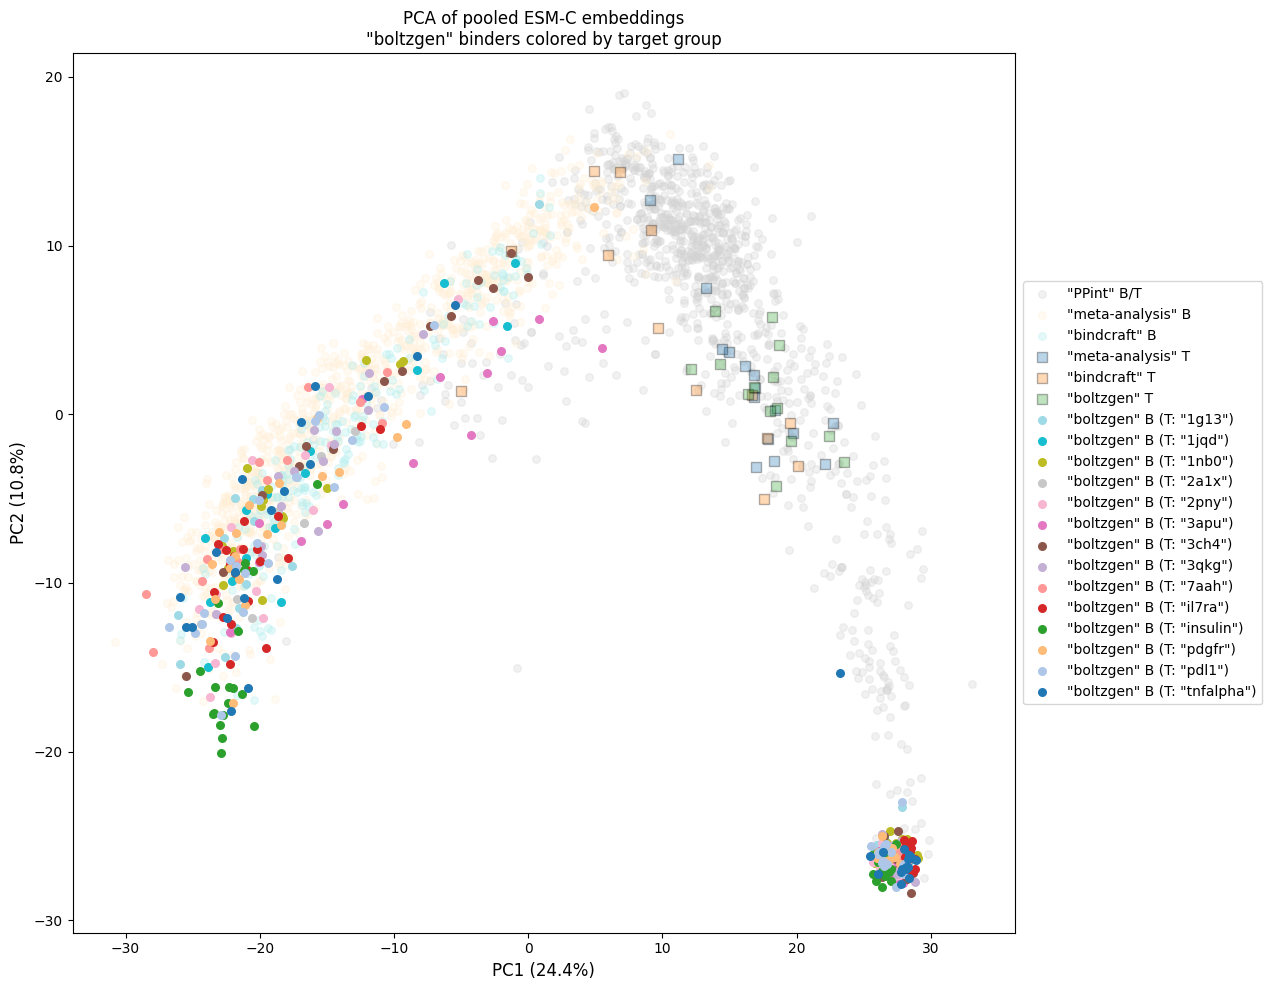

In [9]:
# 1) Pool per-sample (mean over residues) -> (Ni, 1152)
pooled_PPintDB            = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)           # (N1, 1152)
pooled_boltzgen_binders   = np.stack([arr.mean(axis=0) for arr in boltzgen_binders_embedings], axis=0)   # (N2, 1152)
pooled_boltzgen_targets   = np.stack([arr.mean(axis=0) for arr in boltzgen_targets_embedings], axis=0)   # (N3, 1152)
pooled_meta_binders       = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)       # (N4, 1152)
pooled_meta_targets       = np.stack([arr.mean(axis=0) for arr in meta_targets_embedings], axis=0)       # (N5, 1152)
pooled_bindcraft_binders   = np.stack([arr.mean(axis=0) for arr in bindcraft_binders_embedings], axis=0)   # (N2, 1152)
pooled_bindcraft_targets   = np.stack([arr.mean(axis=0) for arr in bindcraft_targets_embedings], axis=0)   # (N3, 1152)

# 2) Standardize jointly (important!)
X_all = np.vstack([
    pooled_PPintDB,
    pooled_meta_binders,
    pooled_meta_targets,
    pooled_boltzgen_binders,
    pooled_boltzgen_targets,
    pooled_bindcraft_binders,
    pooled_bindcraft_targets
]) 

X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3+N4+N5, 2)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]
N4 = pooled_boltzgen_binders.shape[0]
N5 = pooled_boltzgen_targets.shape[0]
N6 = pooled_bindcraft_binders.shape[0]
N7 = pooled_bindcraft_targets.shape[0]

# 5) Plot
plt.figure(figsize=(13, 10)) # Increased width for larger legend

# Plot base datasets
plt.scatter(Z_PPintDB[:, 0], Z_PPintDB[:, 1], s=30, alpha=0.3, label='"PPint" B/T', marker='o', color='lightgrey')
plt.scatter(Z_meta_binders[:, 0], Z_meta_binders[:, 1], s=30, alpha=0.3, label='"meta-analysis" B', marker='o', color='papayawhip')
plt.scatter(Z_bindcraft_binders[:, 0], Z_bindcraft_binders[:, 1], s=30, alpha=0.3, label='"bindcraft" B', marker='o', color='paleturquoise')
plt.scatter(Z_meta_targets[:, 0], Z_meta_targets[:, 1], s=60, alpha=0.3, label='"meta-analysis" T', marker='s', edgecolors='black')
plt.scatter(Z_bindcraft_targets[:, 0], Z_bindcraft_targets[:, 1], s=60, alpha=0.3, label='"bindcraft" T', marker='s', edgecolors='black')
plt.scatter(Z_boltzgen_targets[:, 0], Z_boltzgen_targets[:, 1], s=60, alpha=0.3, label='"boltzgen" T', marker='s', edgecolors='black')

# --- NEW: Color Boltzgen binders by their targets ---
# Assuming boltzgen_groups is a list of strings/IDs of the same length as Z_boltzgen_binders
unique_groups = sorted(list(set(boltzgen_groups)))
colors = cm.get_cmap('tab20_r', len(unique_groups)) # Use a qualitative colormap
# colors = ["dodgerblue", "orange", "pink", "green", "red", "purple", "cyan", "gold", "yellow", "limegreen", "lightpink", "olive", "greenyellow", "brown"]

for i, group_id in enumerate(unique_groups):
    # Mask for binders belonging to this specific target group
    idx = [j for j, g in enumerate(boltzgen_groups) if g == group_id]
    plt.scatter(Z_boltzgen_binders[idx, 0], Z_boltzgen_binders[idx, 1], s=30, alpha=1, label=f'"boltzgen" B (T: "{group_id}")', color=colors(i))

# Plot remaining datasets

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
plt.title('PCA of pooled ESM-C embeddings\n"boltzgen" binders colored by target group')
plt.legend(bbox_to_anchor=(1.27, 0.5), loc='center right', fontsize='medium') # Move legend outside
plt.tight_layout()
plt.show()

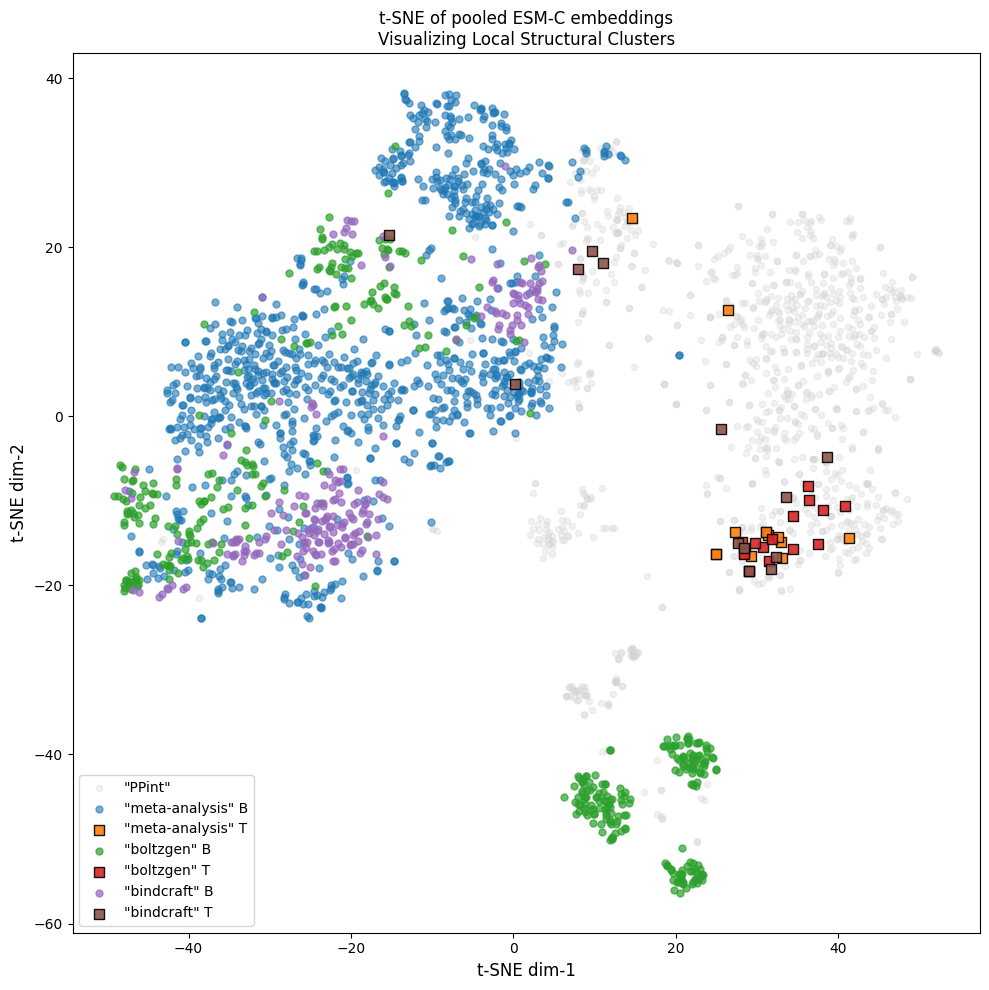

In [10]:
# --- Step 1 & 2: Same as your existing pooling and standardization ---
X_all = np.vstack([
    pooled_PPintDB,
    pooled_meta_binders,
    pooled_meta_targets,
    pooled_boltzgen_binders,
    pooled_boltzgen_targets,
    pooled_bindcraft_binders,
    pooled_bindcraft_targets
]) 

X_all_std = StandardScaler().fit_transform(X_all)

# --- Step 3: t-SNE Analysis ---
# Perplexity is the most important hyperparameter (usually 30-50).
# Learning rate 'auto' and init 'pca' are recommended for stability.
tsne = TSNE(n_components=2, perplexity=40, learning_rate='auto', init='pca', random_state=0)
Z_all = tsne.fit_transform(X_all_std)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]
N4 = pooled_boltzgen_binders.shape[0]
N5 = pooled_boltzgen_targets.shape[0]
N6 = pooled_bindcraft_binders.shape[0]
N7 = pooled_bindcraft_targets.shape[0]

Z_PPintDB            = Z_all[:N1]
Z_meta_binders       = Z_all[N1:N1+N2]
Z_meta_targets       = Z_all[N1+N2:N1+N2+N3]  # remaining rows
Z_boltzgen_binders   = Z_all[N1+N2+N3:N1+N2+N3+N4]
Z_boltzgen_targets   = Z_all[N1+N2+N3+N4:N1+N2+N3+N4+N5]
Z_bindcraft_binders   = Z_all[N1+N2+N3+N4+N5:N1+N2+N3+N4+N5+N6]
Z_bindcraft_targets   = Z_all[N1+N2+N3+N4+N5+N6:N1+N2+N3+N4+N5+N6+N7]

# --- Step 5: Plotting ---
plt.figure(figsize=(10, 10))

# Fixed colors for consistency
plt.scatter(Z_PPintDB[:, 0], Z_PPintDB[:, 1], s=20, alpha=0.3, label='"PPint"', color='lightgrey')
plt.scatter(Z_meta_binders[:, 0], Z_meta_binders[:, 1], s=25, alpha=0.6, label='"meta-analysis" B', marker='o')
plt.scatter(Z_meta_targets[:, 0], Z_meta_targets[:, 1], s=50, alpha=0.9, label='"meta-analysis" T', marker='s', edgecolors='black')

plt.scatter(Z_boltzgen_binders[:, 0], Z_boltzgen_binders[:, 1], s=25, alpha=0.7, label='"boltzgen" B', marker='o')
plt.scatter(Z_boltzgen_targets[:, 0], Z_boltzgen_targets[:, 1], s=50, alpha=0.9, label='"boltzgen" T', marker='s', edgecolors='black')

plt.scatter(Z_bindcraft_binders[:, 0], Z_bindcraft_binders[:, 1], s=25, alpha=0.7, label='"bindcraft" B', marker='o')
plt.scatter(Z_bindcraft_targets[:, 0], Z_bindcraft_targets[:, 1], s=50, alpha=0.9, label='"bindcraft" T', marker='s', edgecolors='black')

plt.xlabel("t-SNE dim-1", fontsize=12)
plt.ylabel("t-SNE dim-2", fontsize=12)
plt.title('t-SNE of pooled ESM-C embeddings\nVisualizing Local Structural Clusters')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3337461/2698663243.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20_r', len(unique_groups)) # Use a qualitative colormap


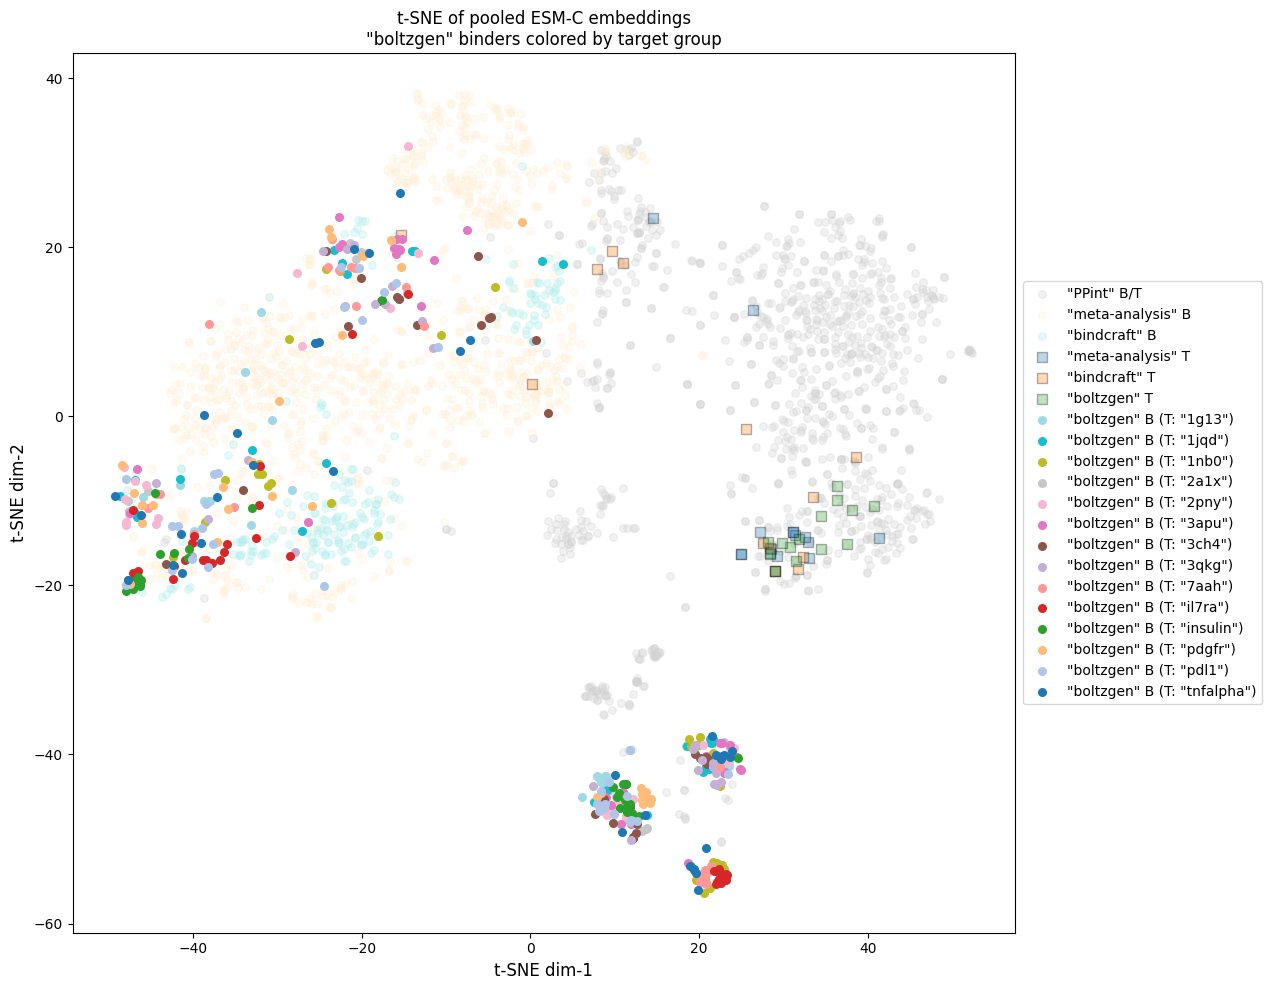

In [11]:
# --- Step 1 & 2: Same as your existing pooling and standardization ---
X_all = np.vstack([
    pooled_PPintDB,
    pooled_meta_binders,
    pooled_meta_targets,
    pooled_boltzgen_binders,
    pooled_boltzgen_targets,
    pooled_bindcraft_binders,
    pooled_bindcraft_targets
]) 

X_all_std = StandardScaler().fit_transform(X_all)

# --- Step 3: t-SNE Analysis ---
# Perplexity is the most important hyperparameter (usually 30-50).
# Learning rate 'auto' and init 'pca' are recommended for stability.
tsne = TSNE(n_components=2, perplexity=40, learning_rate='auto', init='pca', random_state=0)
Z_all = tsne.fit_transform(X_all_std)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]
N4 = pooled_boltzgen_binders.shape[0]
N5 = pooled_boltzgen_targets.shape[0]
N6 = pooled_bindcraft_binders.shape[0]
N7 = pooled_bindcraft_targets.shape[0]

# 5) Plot
plt.figure(figsize=(13, 10)) # Increased width for larger legend

# Plot base datasets
plt.scatter(Z_PPintDB[:, 0], Z_PPintDB[:, 1], s=30, alpha=0.3, label='"PPint" B/T', marker='o', color='lightgrey')
plt.scatter(Z_meta_binders[:, 0], Z_meta_binders[:, 1], s=30, alpha=0.3, label='"meta-analysis" B', marker='o', color='papayawhip')
plt.scatter(Z_bindcraft_binders[:, 0], Z_bindcraft_binders[:, 1], s=30, alpha=0.3, label='"bindcraft" B', marker='o', color='paleturquoise')
plt.scatter(Z_meta_targets[:, 0], Z_meta_targets[:, 1], s=60, alpha=0.3, label='"meta-analysis" T', marker='s', edgecolors='black')
plt.scatter(Z_bindcraft_targets[:, 0], Z_bindcraft_targets[:, 1], s=60, alpha=0.3, label='"bindcraft" T', marker='s', edgecolors='black')
plt.scatter(Z_boltzgen_targets[:, 0], Z_boltzgen_targets[:, 1], s=60, alpha=0.3, label='"boltzgen" T', marker='s', edgecolors='black')

# --- NEW: Color Boltzgen binders by their targets ---
# Assuming boltzgen_groups is a list of strings/IDs of the same length as Z_boltzgen_binders
unique_groups = sorted(list(set(boltzgen_groups)))
colors = cm.get_cmap('tab20_r', len(unique_groups)) # Use a qualitative colormap
# colors = ["dodgerblue", "orange", "pink", "green", "red", "purple", "cyan", "gold", "yellow", "limegreen", "lightpink", "olive", "greenyellow", "brown"]

for i, group_id in enumerate(unique_groups):
    # Mask for binders belonging to this specific target group
    idx = [j for j, g in enumerate(boltzgen_groups) if g == group_id]
    plt.scatter(Z_boltzgen_binders[idx, 0], Z_boltzgen_binders[idx, 1], s=30, alpha=1, label=f'"boltzgen" B (T: "{group_id}")', color=colors(i))

# Plot remaining datasets

plt.xlabel("t-SNE dim-1", fontsize=12)
plt.ylabel("t-SNE dim-2", fontsize=12)
plt.title('t-SNE of pooled ESM-C embeddings\n"boltzgen" binders colored by target group')
plt.legend(bbox_to_anchor=(1.27, 0.5), loc='center right', fontsize='medium') # Move legend outside
plt.tight_layout()
plt.show()

In [20]:
import torch
import torch.nn.functional as F
import numpy as np

def get_average_similarity(dataset_a, dataset_b):
    """
    Computes the mean pooled cosine similarity between all pairs 
    of two groups of numpy arrays.
    """
    # 1. Mean pool and convert to tensors
    pooled_a = torch.stack([torch.from_numpy(emb.mean(axis=0)) for emb in dataset_a])
    pooled_b = torch.stack([torch.from_numpy(emb.mean(axis=0)) for emb in dataset_b])
    
    # 2. Normalize to unit length for cosine similarity via matrix multiplication
    norm_a = F.normalize(pooled_a, p=2, dim=1)
    norm_b = F.normalize(pooled_b, p=2, dim=1)
    
    # 3. Compute pairwise similarity matrix (N x M)
    # Result[i, j] is the similarity between target_a[i] and target_b[j]
    sim_matrix = torch.mm(norm_a, norm_b.t())
    
    # 4. Return the global average
    return sim_matrix.mean().item()

# --- Execution ---

# Calculate Average for Meta vs Boltzgen
avg_sim_boltzgen = get_average_similarity(meta_targets, boltzgen_targets)
print(f"Average Similarity (Meta vs Boltzgen): {avg_sim_boltzgen:.4f}")

# Calculate Average for Meta vs Bindcraft
avg_sim_bindcraft = get_average_similarity(meta_targets, bindcraft_targets)
print(f"Average Similarity (Meta vs Bindcraft): {avg_sim_bindcraft:.4f}")

Average Similarity (Meta vs Boltzgen): 0.8068
Average Similarity (Meta vs Bindcraft): 0.7500
